# Inferencing Coarse Tuning Model

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

import yaml

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


In [4]:
#!scp apaurevi@cedar.computecanada.ca:projects/def-baugh/apaurevi/QuantumDotControl/output/model_0004999.pth ./output/model_bias_traingles.pth

In [19]:
# Load trained model path
model_path = os.path.join("../output", "model_bias_triangles.pth")  # path to the model we just trained
model_name = 'psb'
print(model_path)

../output/model_bias_triangles.pth


In [20]:
config_path = "./config.yaml"

processor = 'cpu'

with open(config_path, 'r') as config_yaml:
            model_yaml = yaml.load(config_yaml, Loader=yaml.FullLoader)
            model_config = model_yaml[model_name]
            model_info = model_config['info']
            model_hyperparams = model_config['hyperparameters']

            model_device = model_yaml['device']

ROOT_DIR = "../../../autotuning/data/bias_triangles"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")

In [51]:
from detectron2.engine import DefaultTrainer

print(model_hyperparams)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bias_triangle_train",)
cfg.DATASETS.TEST = ()

cfg.MODEL.DEVICE = processor 
cfg.DATALOADER.NUM_WORKERS = model_device[processor]['num_workers']

cfg.SOLVER.IMS_PER_BATCH = model_hyperparams['batch_num']
cfg.SOLVER.BASE_LR = model_hyperparams['learning_rate']
cfg.SOLVER.MAX_ITER = model_hyperparams['num_epochs']
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = model_hyperparams['batch_size_per_img']
cfg.MODEL.ROI_HEADS.NUM_CLASSES = model_info['num_of_classes'] 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/fine_tuning/output/model_bias_triangles_5000.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75  # set a custom testing threshold
predictor = DefaultPredictor(cfg)


{'learning_rate': 0.0002, 'augments_per_sim_img': 2, 'augments_per_exp_img': 50, 'num_epochs': 5000, 'batch_num': 1, 'batch_size_per_img': 128}
[04/17 10:07:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/fine_tuning/output/model_bias_triangles_5000.pth ...


In [52]:
def get_bias_triangles_dict(img_dir):
    json_file = os.path.join(img_dir, "via_bias_triangle_11Apr2024_12h19m_json.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        record["file_name"] = os.path.join(img_dir, v["filename"])
        record["image_id"] = idx

        annos = v["regions"]

        objs = []

        if type(annos) == list: # custom JSONs are in list format need to make them the same
             annos = dict(enumerate(annos))

        for _, anno in annos.items():

            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            # if len(px) <= 10 or len(py) <= 10:
            #         # print("Ignoring polygon from ", v["filename"], "because a polygon was too small for detectron2.")
            #         continue
            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            category_dict = {"unblocked":0, "blocked":1}
            category_id = category_dict[regions["label"]]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

## Validation

In [46]:
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("bias_triangles" + d, lambda d=d: get_bias_triangles_dict(os.path.join(MODEL_DATA_DIR,d)))
    MetadataCatalog.get("bias_triangles" + d).set(thing_classes=list(model_info['class_dict'].keys()))

csd_train_metadata = MetadataCatalog.get("bias_triangles_train")
csd_val_metadata = MetadataCatalog.get("bias_triangles_val")

def check_image_exists(directory, image_name):
    # Get the list of files in the directory
    files = os.listdir(directory)

    # Check if the image_name exists with any image extension
    for file in files:
        if file == image_name:
            print(file, image_name)
            return True

    return False

dataset_dicts = get_bias_triangles_dict(MODEL_VAL_DATA_DIR)
for d in random.sample(dataset_dicts, 1):    

    im = cv2.imread(d['file_name'])

    

    print(d['file_name'])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    v = Visualizer(im[:, :, ::-1],
                   metadata=csd_val_metadata, 
                   scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    
    plt.cla()
    plt.clf()
    plt.close()
    visualizer = Visualizer(im[:, :, ::-1], metadata=csd_val_metadata, scale=3)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1],cmap=cm.summer)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../../autotuning/data/bias_triangles/processed/val/via_bias_triangle_11Apr2024_12h19m_json.json'

## Experimental Test

[1] None
tensor(1) tensor(0.9493)


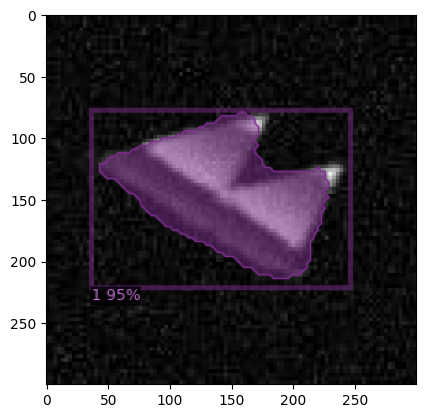

In [224]:
test_image = os.path.join(MODEL_TEST_DATA_DIR, "test_44_1_sim_blocked.jpg")
im = cv2.imread(test_image)
im = cv2.rotate(im, cv2.ROTATE_180)
im_blur = cv2.bilateralFilter(im, 3,50,50)
gray = cv2.cvtColor(im_blur, cv2.COLOR_BGR2GRAY)
# Define the sharpening kernel (Laplacian)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# # Apply the kernel to the image using filter2D
# sharpened_image = cv2.filter2D(gray, -1, kernel)

# plt.imshow(sharpened_image)
# plt.colorbar()
# plt.show()

# # sobelxy = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3) # Combined X and Y Sobel Edge Detection
# # plt.imshow(cv2.rotate(sobelxy.astype('uint8'), cv2.ROTATE_180))
# # plt.colorbar()
# # plt.show()


# # im_adap_thres = cv2.adaptiveThreshold(sobelxy.astype('uint8'),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# #  cv2.THRESH_BINARY_INV,21,25)

# # # plt.imshow(im_thres)
# # # plt.colorbar()
# # # plt.show()
# # # im = cv2.cvtColor(im_thres, cv2.COLOR_GRAY2RGB)
# # # plt.imshow(im)
# # # plt.colorbar()
# # # plt.show()
# # im = cv2.rotate(im_adap_thres, cv2.ROTATE_180)
# # plt.imshow(im)
# # plt.colorbar()
# # plt.show()
# # im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

# # im = cv2.rotate(sobelxy.astype('uint8'), cv2.ROTATE_180)
# im = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
# im = cv2.rotate(im, cv2.ROTATE_180)
# plt.imshow(im)
# plt.colorbar()
# plt.show()
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
bias_triangle_test_metadata = MetadataCatalog.get("bias_triangles_val")
v = Visualizer(im[:, :, ::-1],
                metadata=bias_triangle_test_metadata, 
                scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
instances = outputs["instances"].to("cpu")
for i in range(len(instances)):
    mask = instances.pred_masks[i]

    confidence_score = instances.scores[i]
    class_label = instances.pred_classes[i]
    print(class_label, confidence_score)
    
plt.imshow(out.get_image())

plt.show()

In [225]:
from skimage import measure
def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

def mask_to_polygon(binary_mask, tolerance=0):
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)

    return polygons

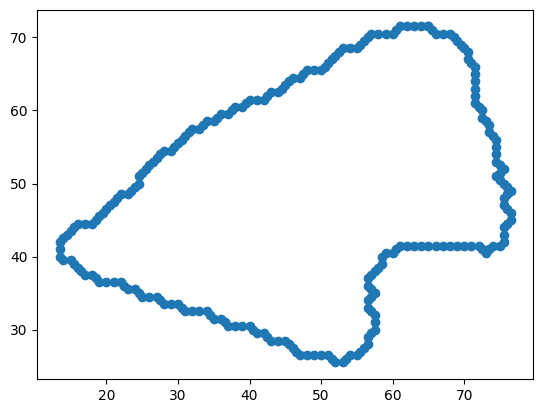

In [226]:
poly = np.array(mask_to_polygon(mask.numpy().astype(int))).reshape(-1,2)
xs = poly[:,0]
ys = poly[:,1]
plt.scatter(xs,ys)

Number of coordinates: 229 6


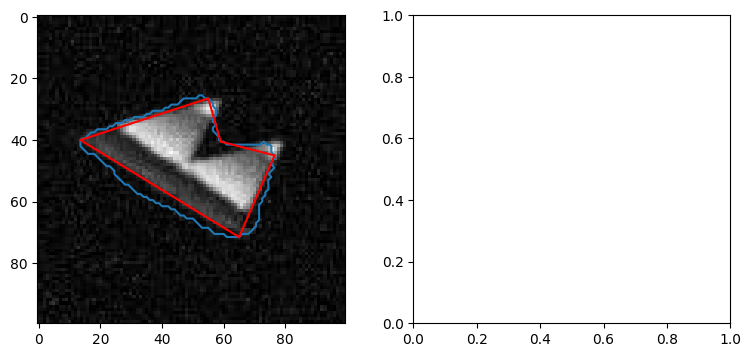

In [227]:
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

# approximate subdivided polygon with Douglas-Peucker algorithm
appr_poly = approximate_polygon(poly, tolerance=6)

print("Number of coordinates:", len(poly),len(appr_poly))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.imshow(im)
ax1.plot(poly[:, 0], poly[:, 1])

ax1.plot(appr_poly[:, 0], appr_poly[:, 1],'r')


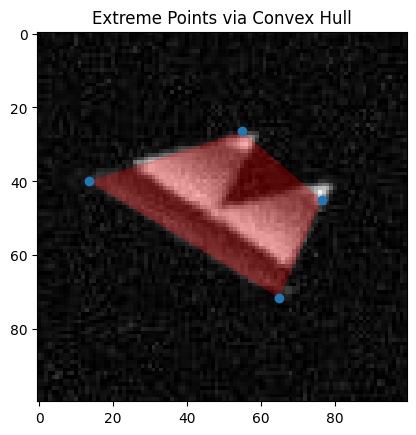

In [228]:
# Combine x and y coordinates into a list of tuples
xs = appr_poly[:,0]
ys = appr_poly[:,1]
points = list(zip(xs, ys))

import scipy

# Compute the convex hull of the points
hull = scipy.spatial.ConvexHull(points)

# Get the indices of the vertices forming the convex hull
hull_indices = hull.vertices

# Get the coordinates of the vertices forming the convex hull
convex_hull_points = [points[i] for i in hull_indices]
chull_points = np.array(convex_hull_points)

def dist(p1, p2):
    x1,y1 = p1
    x2,y2 = p2

    d = ((x2-x1)**2 + (y2-y1)**2)**0.5
    return d

def slope(p1, p2):
    x1,y1 = p1
    x2,y2 = p2

    m = (y2-y1)/(x2-x1)
    return m

xs, ys = chull_points[:,0],chull_points[:,1] 
points = list(zip(xs,ys))


corners_dict = {}
for i in range(len(points)+1):
    index1, index2 = i % len(points), (i+1) % len(points)
    p1, p2 = points[i % len(points)], points[(i+1) % len(points)]
    d = dist(p1,p2)
    m = slope(p1,p2)
    corners_dict[(index1,index2)] = {'dist': d, 'slope': m}

corners_dict_sorted = dict(sorted(corners_dict.items(), key=lambda item: item[1]['dist']))

min_dist = corners_dict_sorted[list(corners_dict_sorted.keys())[0]]['dist']
max_dist = corners_dict_sorted[list(corners_dict_sorted.keys())[-1]]['dist']
plt.imshow(im)
plt.fill(xs, ys, 'r-', alpha=0.3)  # Connect the last point to the first to close the polygon
plt.scatter(xs ,ys)
plt.title("Extreme Points via Convex Hull")
plt.show()

im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

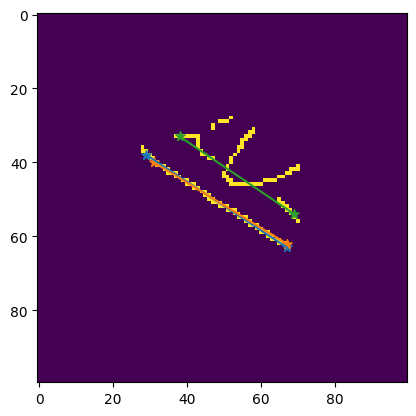

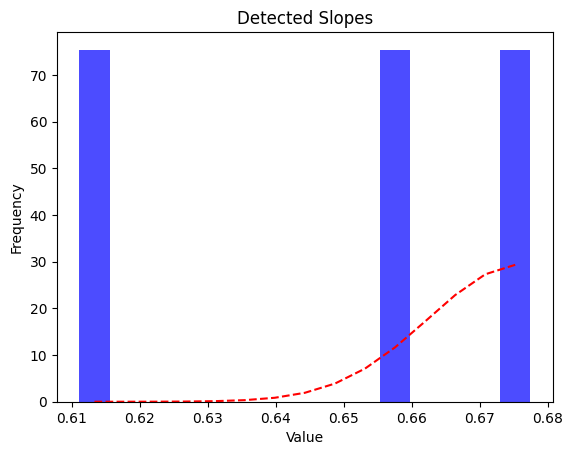

Fitted Mean: 0.6759935834083608
Fitted Standard Deviation: 0.013576401407207738
[((0, 1), {'dist': 60.36969438385455, 'slope': 0.6116504854368932, 'prob': 0.00038969010077684996}), ((2, 3), {'dist': 28.36370920736567, 'slope': 0.8604651162790697, 'prob': 2.3846291232647576e-39}), ((3, 0), {'dist': 28.88771365130858, 'slope': -2.3043478260869565, 'prob': 0.0}), ((1, 2), {'dist': 43.64057744805859, 'slope': -0.3253012048192771, 'prob': 0.0})]
Key with the highest prob and highest dist: (0, 1)


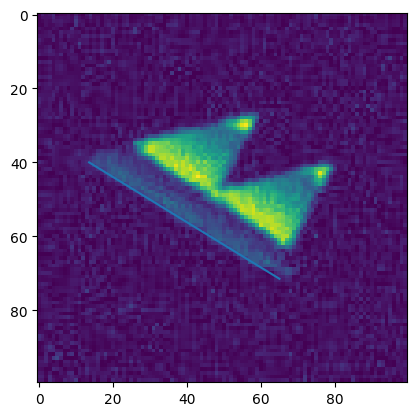

In [229]:
import scipy.optimize
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny



def create_polygon_mask(image_shape, polygon_points):
    # Create a blank mask image
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    # Convert polygon points to numpy array format
    pts = np.array(polygon_points, np.int32)
    
    # Reshape points array into the required shape for fillPoly
    pts = pts.reshape((-1, 1, 2))
    
    # Draw filled polygon on the mask
    cv2.fillPoly(mask, [pts], 255)
    
    return mask

mask = create_polygon_mask(im.shape, chull_points)

edges = canny(im,sigma=2.5, mask=mask)

lines = probabilistic_hough_line(edges, line_length=int(np.average([min_dist, max_dist])/1.5))

slopes = []
yints = []
points =[]
for line in lines:
    p0, p1 = line
    if slope == 0 or (p1[0]-p0[0]) == 0 :
        continue
    slope = (p1[1]-p0[1])/(p1[0]-p0[0])
    yint = p1[1] - slope * p1[0]
    yints.append(yint)
    slopes.append(slope)
    points.append((p0,p1))

    plt.scatter((p0[0], p1[0]), (p0[1], p1[1]), marker='*',s=50)
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
median_index = np.argsort(np.array(yints))[len(np.array(yints))//2]
median_point = points[median_index]
plt.imshow(edges)
plt.show()

# Sample data

# Create histogram
hist, bins = np.histogram(slopes, bins=15, density=True)

# Find bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Fit histogram data to a Gaussian distribution
(mu, sigma) = scipy.stats.norm.fit(im)

# Define Gaussian function
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Fit the Gaussian function to the histogram data
popt, _ = scipy.optimize.curve_fit(gaussian, bin_centers, hist, p0=[mu, sigma])

# Plot histogram
plt.hist(slopes, bins=15, density=True, alpha=0.7, color='blue', label='Histogram')

# Plot fitted Gaussian
plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label='Fitted Gaussian')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Detected Slopes')
# plt.legend()
plt.show()

# Print mean and standard deviation of the fitted Gaussian
print("Fitted Mean:", popt[0])
print("Fitted Standard Deviation:", popt[1])

for indices, info in corners_dict_sorted.items():

    slope=info['slope']
    # Calculate the PDF of the fitted Gaussian at the given slope
    pdf_at_slope = scipy.stats.norm.pdf(slope, loc=popt[0], scale=popt[1])
    info['prob'] = pdf_at_slope
    # Print the probability

# Sort the dictionary based on 'prob' and then 'dist' keys in descending order
sorted_data = sorted(corners_dict_sorted.items(), key=lambda x: (np.abs(x[1]['prob'])**2 * x[1]['dist']), reverse=True)
print(sorted_data)
# Get the key with the highest prob and highest dist
key_with_highest_prob_and_dist = sorted_data[0][0]

# Print the key
print("Key with the highest prob and highest dist:", key_with_highest_prob_and_dist)

best_p1, best_p2 = chull_points[key_with_highest_prob_and_dist[0]], chull_points[key_with_highest_prob_and_dist[1]]
base_line = np.array([best_p1, best_p2])
plt.imshow(im)
plt.plot(base_line[:,0], base_line[:,1])
plt.show()


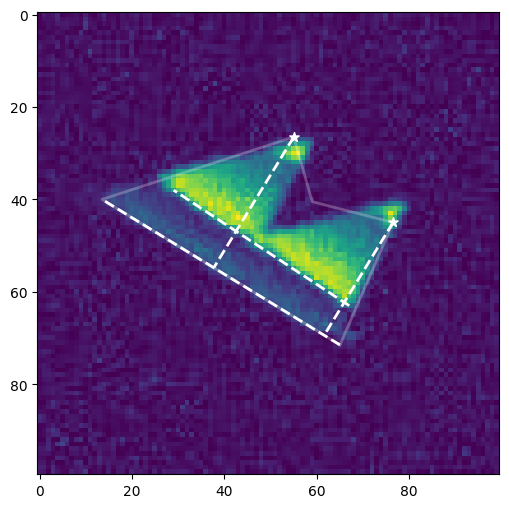

In [230]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_perpendicular_line(point1, point2, point):
    """Calculate the perpendicular line from a point to a line defined by two points."""
    # Calculate the slope of the original line
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0] + 1e-10)  # Avoid division by zero

    # Calculate the perpendicular slope
    slope_perpendicular = -1 / slope

    # Calculate the x-coordinate of the intersection point
    x_intersection = (point[1] - point1[1] + slope * point1[0] - slope_perpendicular * point[0]) / (slope - slope_perpendicular)

    # Calculate the y-coordinate of the intersection point
    y_intersection = slope * (x_intersection - point1[0]) + point1[1]

    return (x_intersection, y_intersection)

# Example points
point1 = base_line[0]
point2 = base_line[1]
testpoint1 = chull_points[3]
testpoint2 = chull_points[2]
intersection_point1 = calculate_perpendicular_line(point1, point2, testpoint1)
intersection_point2 = calculate_perpendicular_line(point1, point2, testpoint2)
plt.figure(figsize=(8, 6))
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='white', linestyle='--', linewidth=2, label='Baseline')
plt.plot([testpoint1[0], intersection_point1[0]], [testpoint1[1], intersection_point1[1]], color='white', linestyle='--', linewidth=2, label='Detuning Axis')
plt.plot([testpoint2[0], intersection_point2[0]], [testpoint2[1], intersection_point2[1]], color='white', linestyle='--', linewidth=2, label='Detuning Axis')
plt.scatter(testpoint1[0], testpoint1[1], color='white',marker='*',s=50)
plt.scatter(testpoint2[0], testpoint2[1], color='white',marker='*',s=50)
plt.plot(appr_poly[:, 0], appr_poly[:, 1],linewidth=2, color='white',alpha=0.25)
p1, p2 = median_point
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=2, color='white', linestyle='--')

plt.imshow(im)
# plt.legend(loc='best')
plt.show()
